In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from pandas import DataFrame
from pandas import concat
from itertools import chain
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt

**模型设计思路**：  
因为pm2.5数据集中特征比较多，并且从可视化结果上看趋势性并不是很明显，airma在这里不如LSTM神经网络的效果更好。所以整体的设计思路还是将数据集进行预处理，并变形成一个监督式学习的形式，然后根据lstm的输入格式构建一个lstm网络结构（时序模型用一个lstm层和一个输出层输出结果，同时用滑动窗口得形式来逐个训练）。最终使用测试集来预测结果并与真实值进行比较。

## 读取数据

In [2]:
# 数据加载
df = pd.read_csv('../L9/pm2.5/pollution.csv', index_col = 0) # 这里将dataframe的index换成date（第0列）
df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


## 数据预处理

对每个特征进行可视化

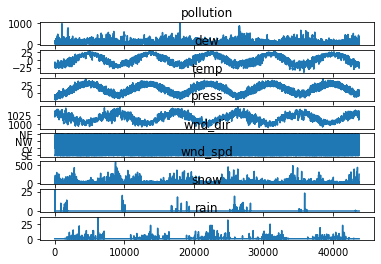

In [4]:
i = 1
for group in range(8):
    plt.subplot(8, 1, i)
    plt.plot(df.values[: , group])
    plt.title(df.columns[group])
    i = i + 1
plt.show()

对wnd_dir也就是风向进行label编码，使得可以被模型读取

In [5]:
values = df.values
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
values = values.astype('float32')
values

array([[129.  , -16.  ,  -4.  , ...,   1.79,   0.  ,   0.  ],
       [148.  , -15.  ,  -4.  , ...,   2.68,   0.  ,   0.  ],
       [159.  , -11.  ,  -5.  , ...,   3.57,   0.  ,   0.  ],
       ...,
       [ 10.  , -22.  ,  -3.  , ..., 242.7 ,   0.  ,   0.  ],
       [  8.  , -22.  ,  -4.  , ..., 246.72,   0.  ,   0.  ],
       [ 12.  , -21.  ,  -3.  , ..., 249.85,   0.  ,   0.  ]],
      dtype=float32)

将所有数据根据列做归一化

In [6]:
# 在这里调用sklearn中的归一化函数，并用fit_transform完成归一化
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

将时序数据转化成监督学习的数据
（这一步将dataframe本身和dataframe.shift(-1)进行连接，即完成了滑动窗口的工作，）

In [7]:
'''
这个函数用于把时间序列数据转化成监督学习的数据.
在pm2.5预测项目中作用是将预处理完的时序数据，整合成当前观测步长（n_in）（也就是监督学习中的x）
+预测步长为1的（也就是将下一个时序作为观测x的y）的形式。
'''
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # 拼接到一起
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
# 转换成监督学习数据后，drop掉不需要检测的9：15列并保存成csv
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[9:16], axis=1, inplace=True)
reframed.to_csv('reframed2model.csv')

## 预处理后的数据进行数据集划分

In [9]:
# 注意时序数据模型不能进行随机抽样划分
values = reframed.values
# 处理完的数据按照0.8，0.2比例前后划分训练集和测试集
n_train_hours = int(len(values) *0.8)
train = values[:n_train_hours,:]
test = values[n_train_hours:, :]

# 每个数据集将除了最后一列数据作为训练数据，最后一列为label
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

## 针对不同的模型分别训练
### LSTM
#### 根据LSTM的输入要求对数据变形

In [10]:
# LSTM的输入要有三个，所以对train_x进行reshape成3D格式[样本数，时间步，特征数]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

#### 构建模型

In [12]:
# 这里构建LSTM的模型是一个简单LSTM，用一层100个单元的LSTM隐藏层和一个Dense输出层构成。
# 优化器用adam，而最终的预测为回归任务所以用mse作为损失函数。
model = Sequential()
model.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

#### 模型训练

In [13]:
result = model.fit(train_x, train_y, epochs=10, batch_size=64, validation_data=(test_x, test_y), verbose=2, shuffle=False)

Epoch 1/10
548/548 - 2s - loss: 0.0033 - val_loss: 0.0076
Epoch 2/10
548/548 - 1s - loss: 8.5044e-04 - val_loss: 0.0023
Epoch 3/10
548/548 - 1s - loss: 8.0298e-04 - val_loss: 0.0017
Epoch 4/10
548/548 - 1s - loss: 8.0119e-04 - val_loss: 0.0014
Epoch 5/10
548/548 - 1s - loss: 8.0292e-04 - val_loss: 0.0012
Epoch 6/10
548/548 - 1s - loss: 8.0425e-04 - val_loss: 0.0011
Epoch 7/10
548/548 - 1s - loss: 8.0449e-04 - val_loss: 0.0011
Epoch 8/10
548/548 - 1s - loss: 8.0439e-04 - val_loss: 0.0011
Epoch 9/10
548/548 - 1s - loss: 8.0417e-04 - val_loss: 0.0010
Epoch 10/10
548/548 - 1s - loss: 8.0385e-04 - val_loss: 0.0011


#### 模型预测

In [14]:
train_predict = model.predict(train_x)
test_predict = model.predict(test_x)

In [15]:
test_predict

array([[0.02741133],
       [0.028278  ],
       [0.05407941],
       ...,
       [0.0134012 ],
       [0.01338227],
       [0.01178577]], dtype=float32)

#### 模型评估
显示训练损失函数曲线。  
其实从损失函数曲线可以观察出来，模型拟合情况还是不错的，在第6个epoch后就基本已经拟合了。

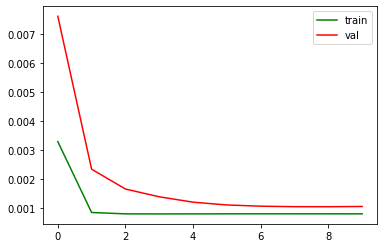

In [16]:
line1 = result.history['loss']
line2 = result.history['val_loss']
plt.plot(line1, label='train', c='g')
plt.plot(line2, label='val', c='r')
plt.legend()
plt.show()

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               43600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 43,701
Trainable params: 43,701
Non-trainable params: 0
_________________________________________________________________


#### 显示训练结果预测结果以及原始数据对比

In [18]:
def plot_img(source_data, train_predict, test_predict):
    plt.plot(source_data[:, -1], label='real', c='b') # 显示所有数据
    plt.plot([x for x in train_predict], label='train_predict', c='g') # 显示训练数据并标记绿色
    plt.plot([None for _ in train_predict] + [x for x in test_predict], label='test_predict', c='r')# 训练数据部分占位，然后用测试数据标记红色
    plt.legend(loc='best')
    plt.show()

C:\Users\kinga\Anaconda3\envs\rs\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


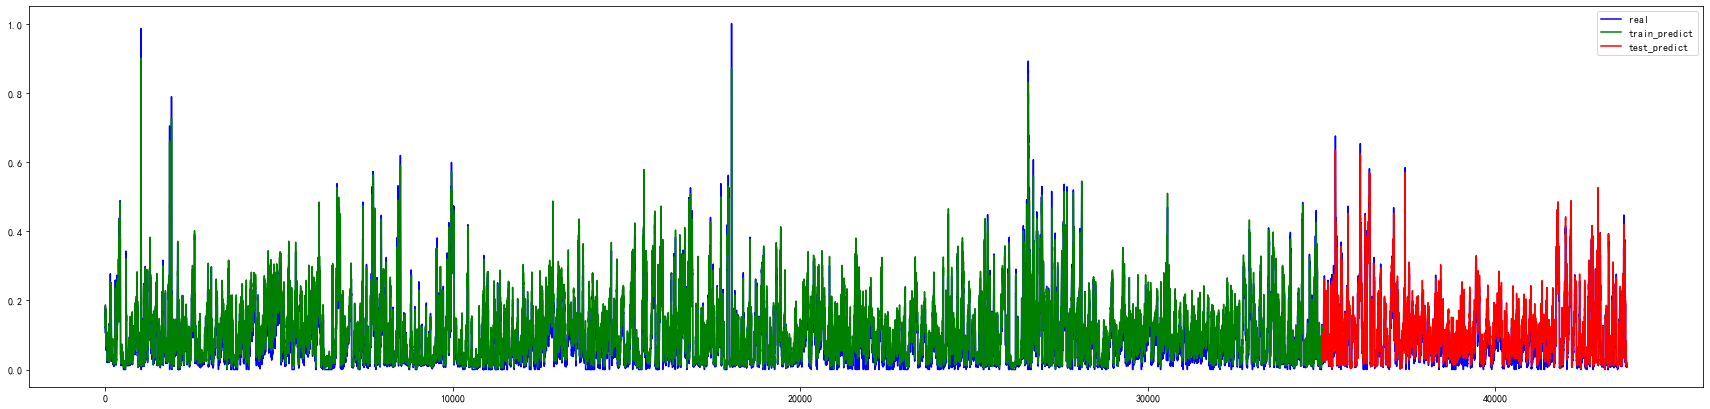

In [70]:
plt.figure(figsize=(30,7))
plot_img(values, train_predict, test_predict)

## 总结
从损失函数曲线和最终的可视化结果可以看出，这个模型的拟合效果还是很好的，训练集和测试集都基本完成了覆盖